In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Лаура\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 29.6 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 43s


А теперь в 3 строчки обучим нашу модель

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [14]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [15]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(1, 0.75564295), (8, 0.092581496), (9, 0.08907197), (23, 0.043790855)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: фотография минск сооружение концерн партнёрство ким представляться
topic_1: планета первый это год день стать хороший
topic_2: военный космонавт иран теория боевой употребление товар
topic_3: снижение мозг это nn исследование тело пациент
topic_4: экономика наука научный повышение рост температура банк
topic_5: фонд параметр лекарство держава малое сектор антонов
topic_6: проект год рост область строительство развитие риск
topic_7: мышь диск приложение автобус компьютер австралия билет
topic_8: миссия граница доллар форум метод гостиница ресторан
topic_9: космос парламент разместить рейтинг греция nn устойчивый
topic_10: это человек который год всё свой весь
topic_11: газ турция турецкий страна тело фестиваль расчёт
topic_12: это год который россия страна мочь российский
topic_13: операция взрыв производитель обнаружить след превысить белый
topic_14: год земля это который автор мочь территория
topic_15: статья рубль поверхность пенсия спрос стоимость гражданин
topic_16: сократ

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.032518,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.039192,0.0,0.0,0.0,0.000000,0.577176,0.0,0.000000,0.0
1,4896,0.0,0.066949,0.0,0.0,0.000000,0.0,0.173962,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.154137,0.0,0.000000,0.0
2,4897,0.0,0.755832,0.0,0.0,0.000000,0.0,0.000000,0.0,0.092787,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.043775,0.0
3,4898,0.0,0.598357,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,4899,0.0,0.000000,0.0,0.0,0.111143,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.159619,0.704735,0.0,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[293622]

array([0.        , 0.11315056, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02786413, 0.        ,
       0.39279982, 0.03379765, 0.        , 0.        , 0.09253748,
       0.        , 0.        , 0.        , 0.07964786, 0.18382759,
       0.0330143 , 0.        , 0.        , 0.        , 0.03365   ])

In [23]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [24]:
get_user_embedding(user_articles_list)

array([0.        , 0.02006671, 0.0218083 , 0.00264381, 0.        ,
       0.        , 0.01271946, 0.        , 0.        , 0.        ,
       0.08653366, 0.00544432, 0.29709406, 0.0207367 , 0.13468348,
       0.        , 0.        , 0.        , 0.00561886, 0.02231261,
       0.00835032, 0.2225568 , 0.00315264, 0.05537241, 0.06607451])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [25]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [26]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [27]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.011274,0.056986,0.000000,0.010711,0.000000,0.0,0.103917,0.000000,0.004644,...,0.000000,0.0,0.018933,0.055108,0.085622,0.068702,0.221848,0.0,0.068366,0.027145
1,u108690,0.000000,0.017684,0.000000,0.028843,0.002494,0.0,0.003669,0.002331,0.000000,...,0.000000,0.0,0.017512,0.085039,0.102008,0.033951,0.105042,0.0,0.058514,0.036463
2,u108339,0.000000,0.020584,0.004457,0.052003,0.012556,0.0,0.048536,0.000000,0.003277,...,0.003742,0.0,0.049624,0.018665,0.109594,0.014449,0.167339,0.0,0.035549,0.019806


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [28]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [29]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.011274,0.056986,0.000000,0.010711,0.000000,0.0,0.103917,0.000000,0.004644,...,0.0,0.018933,0.055108,0.085622,0.068702,0.221848,0.0,0.068366,0.027145,0
1,u108690,0.000000,0.017684,0.000000,0.028843,0.002494,0.0,0.003669,0.002331,0.000000,...,0.0,0.017512,0.085039,0.102008,0.033951,0.105042,0.0,0.058514,0.036463,1
2,u108339,0.000000,0.020584,0.004457,0.052003,0.012556,0.0,0.048536,0.000000,0.003277,...,0.0,0.049624,0.018665,0.109594,0.014449,0.167339,0.0,0.035549,0.019806,1


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [32]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [33]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10380783, 0.05507179, 0.39429554, 0.22100682, 0.12056642,
       0.16069443, 0.21762919, 0.06983513, 0.1381348 , 0.1968238 ])

In [34]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.240829, F-Score=0.647, Precision=0.613, Recall=0.686


In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1649  106]
 [  78  167]]


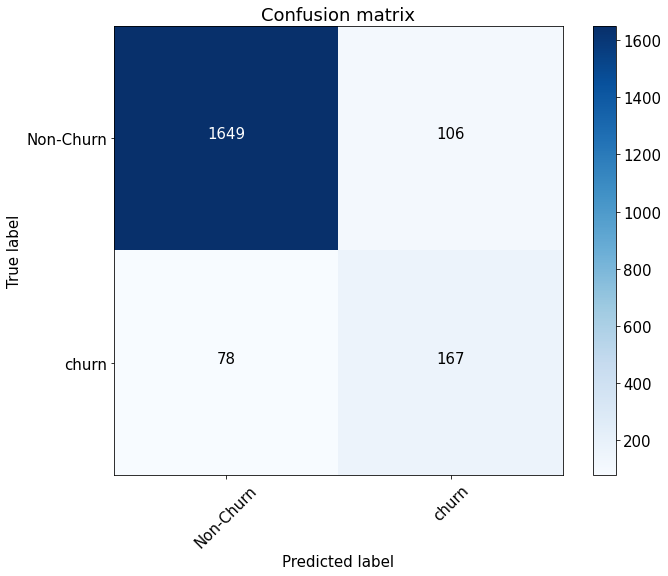

In [37]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [38]:
roc_auc_score(y_test, preds)

0.9378615035757892

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

In [39]:
metric_list=[[i] for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix]]]
metric_list

[[0.24082944574472856],
 [0.6473988439306358],
 [0.6131386861313869],
 [0.6857142857142857]]

### Домашнее задание

#### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)


In [40]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [41]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06970333, 0.        , 0.36379337, 0.00922024, 0.11986435,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11138561, 0.        , 0.01167759, 0.02788817])

In [42]:
user_embeddings1 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings1.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings1['uid'] = users['uid'].values
user_embeddings1 = user_embeddings1[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.044877,0.0,0.000000,0.0,0.0,0.083037,0.0,0.0,...,0.0,0.0,0.000000,0.043396,0.067518,0.026178,0.209769,0.0,0.000000,0.016825
1,u108690,0.0,0.000000,0.0,0.018116,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.094453,0.084662,0.000000,0.042822,0.0,0.051667,0.000000
2,u108339,0.0,0.000000,0.0,0.028929,0.0,0.0,0.028093,0.0,0.0,...,0.0,0.0,0.042306,0.000000,0.110510,0.015454,0.177162,0.0,0.018295,0.007966


In [43]:
X1 = pd.merge(user_embeddings1, target, 'left')
X1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.044877,0.0,0.000000,0.0,0.0,0.083037,0.0,0.0,...,0.0,0.000000,0.043396,0.067518,0.026178,0.209769,0.0,0.000000,0.016825,0
1,u108690,0.0,0.000000,0.0,0.018116,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.094453,0.084662,0.000000,0.042822,0.0,0.051667,0.000000,1
2,u108339,0.0,0.000000,0.0,0.028929,0.0,0.0,0.028093,0.0,0.0,...,0.0,0.042306,0.000000,0.110510,0.015454,0.177162,0.0,0.018295,0.007966,1


In [44]:
#разделим данные на train/test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1[['topic_{}'.format(i) for i in range(25)]], 
                                                    X1['churn'], random_state=0)

In [45]:
logreg1 = LogisticRegression()
#обучим наш пайплайн
logreg1.fit(X_train1, y_train1)

LogisticRegression()

In [46]:
#наши прогнозы для тестовой выборки
preds1 = logreg1.predict_proba(X_test1)[:, 1]
preds1[:10]

array([0.0547428 , 0.06421027, 0.4885918 , 0.23065832, 0.11219453,
       0.03957693, 0.08252949, 0.09623647, 0.17422556, 0.25234519])

In [47]:
precision, recall, thresholds = precision_recall_curve(y_test1, preds1)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.309814, F-Score=0.772, Precision=0.834, Recall=0.718


In [48]:
median_metrics=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrics[i])
metric_list

[[0.24082944574472856, 0.3098139540129458],
 [0.6473988439306358, 0.7719298245614035],
 [0.6131386861313869, 0.8341232227488151],
 [0.6857142857142857, 0.7183673469387755]]

Confusion matrix, without normalization
[[1720   35]
 [  70  175]]


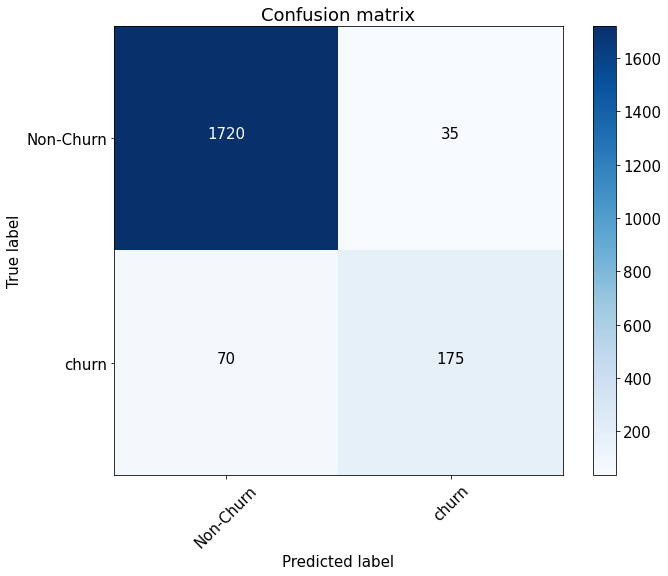

In [49]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test1, preds1>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [50]:
roc_auc_score(y_test1, preds1)

0.9692423978138263

#### 3. Повторить п.2, но используя уже не медиану, а max

In [51]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [52]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.07036564, 0.11625216, 0.01586285, 0.        ,
       0.        , 0.07631674, 0.        , 0.        , 0.        ,
       0.22582741, 0.03266593, 0.5716911 , 0.06161777, 0.40198648,
       0.        , 0.        , 0.        , 0.02023969, 0.09254063,
       0.05010191, 0.68461961, 0.01891584, 0.16760556, 0.17509952])

In [53]:
user_embeddings2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings2.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings2['uid'] = users['uid'].values
user_embeddings2 = user_embeddings2[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.067642,0.139009,0.000000,0.064268,0.000000,0.0,0.270657,0.000000,0.027864,...,0.000000,0.0,0.113600,0.164211,0.194868,0.255033,0.527063,0.0,0.348360,0.077450
1,u108690,0.000000,0.066826,0.000000,0.113866,0.014967,0.0,0.022016,0.013984,0.000000,...,0.000000,0.0,0.053858,0.195726,0.240901,0.122570,0.402728,0.0,0.136007,0.122124
2,u108339,0.000000,0.123503,0.026741,0.157171,0.061635,0.0,0.175192,0.000000,0.019661,...,0.022453,0.0,0.107972,0.060079,0.218310,0.032549,0.311592,0.0,0.124381,0.058644


In [54]:
X2 = pd.merge(user_embeddings2, target, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.067642,0.139009,0.000000,0.064268,0.000000,0.0,0.270657,0.000000,0.027864,...,0.0,0.113600,0.164211,0.194868,0.255033,0.527063,0.0,0.348360,0.077450,0
1,u108690,0.000000,0.066826,0.000000,0.113866,0.014967,0.0,0.022016,0.013984,0.000000,...,0.0,0.053858,0.195726,0.240901,0.122570,0.402728,0.0,0.136007,0.122124,1
2,u108339,0.000000,0.123503,0.026741,0.157171,0.061635,0.0,0.175192,0.000000,0.019661,...,0.0,0.107972,0.060079,0.218310,0.032549,0.311592,0.0,0.124381,0.058644,1


In [55]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X2['churn'], random_state=0)

In [56]:
logreg2 = LogisticRegression()
#обучим 
logreg2.fit(X_train2, y_train2)

LogisticRegression()

In [57]:
#наши прогнозы для тестовой выборки
preds2 = logreg2.predict_proba(X_test2)[:, 1]
preds2[:10]

array([0.08607147, 0.0015623 , 0.655147  , 0.23670587, 0.06576293,
       0.00611608, 0.01548707, 0.01052858, 0.12363972, 0.09220309])

In [58]:
precision, recall, thresholds = precision_recall_curve(y_test2, preds2)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.374573, F-Score=0.744, Precision=0.802, Recall=0.694


In [59]:
max_metrics=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(max_metrics[i])
metric_list

[[0.24082944574472856, 0.3098139540129458, 0.37457296663405737],
 [0.6473988439306358, 0.7719298245614035, 0.7439824945295405],
 [0.6131386861313869, 0.8341232227488151, 0.8018867924528302],
 [0.6857142857142857, 0.7183673469387755, 0.6938775510204082]]

Confusion matrix, without normalization
[[1713   42]
 [  76  169]]


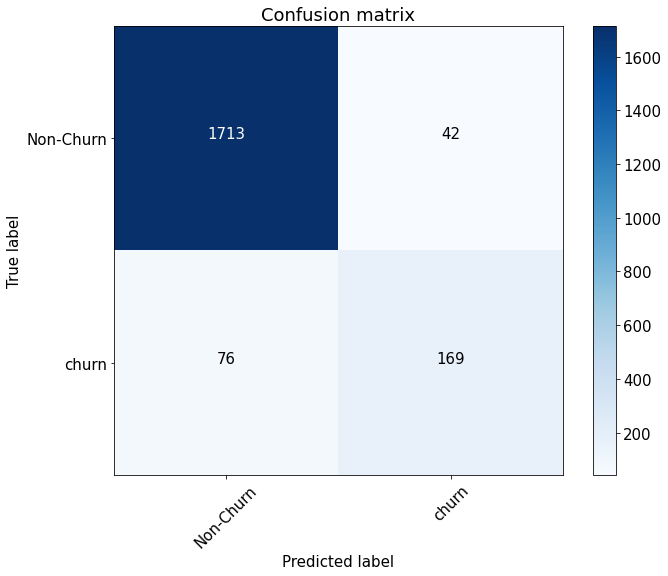

In [60]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test2, preds2>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [61]:
roc_auc_score(y_test2, preds2)

0.9598302226873655

#### 5. Сформировать на выходе единую таблицу, сравнивающую качество 4 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [62]:
metric_df=pd.DataFrame(
    metric_list, columns=['mean','median','max'], index=['Treshhold','F-score','Precision', 'Recall']
).append(pd.DataFrame(
                    [[roc_auc_score(y_test, preds),roc_auc_score(y_test1, preds1),roc_auc_score(y_test2, preds2)]],
    columns=['mean','median','max'],
    index=['ROC-AUC']))
metric_df

,mean,median,max
Treshhold,0.240829,0.309814,0.374573
F-score,0.647399,0.771930,0.743982
Precision,0.613139,0.834123,0.801887
Recall,0.685714,0.718367,0.693878
ROC-AUC,0.937862,0.969242,0.959830


Судя по данным из таблицы, наиболее эффективным оказался метод с использованием медианы. Он позволил нам получить наиболее разреженный вектор заинтересованности пользователя, что даст нам возможность рассмотреть интересы каждого читателя более досконально.